# Blood Donations

## Preamble

In [1]:
%matplotlib inline

In [2]:
ls

Blood Donations.ipynb              BloodDonations-Training.csv
BloodDonationSubmissionFormat.csv  transfusion.data
BloodDonations-Test.csv


In [3]:
import pandas
import seaborn
import matplotlib.pyplot as plt

In [4]:
seaborn.set_style("whitegrid")

## Getting the Data

In [5]:
trainingData = pandas.read_csv("BloodDonations-Training.csv")
testData = pandas.read_csv("BloodDonations-Test.csv")

## First Exploration

In [6]:
trainingData.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [7]:
trainingData.describe()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,374.034722,9.439236,5.427083,1356.770833,34.050347,0.239583
std,216.947773,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,0.000000,1.000000,250.000000,2.000000,0.000000
25%,183.750000,2.000000,2.000000,500.000000,16.000000,0.000000
50%,375.500000,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,562.500000,14.000000,7.000000,1750.000000,49.250000,0.000000
max,747.000000,74.000000,50.000000,12500.000000,98.000000,1.000000


/usr/local/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


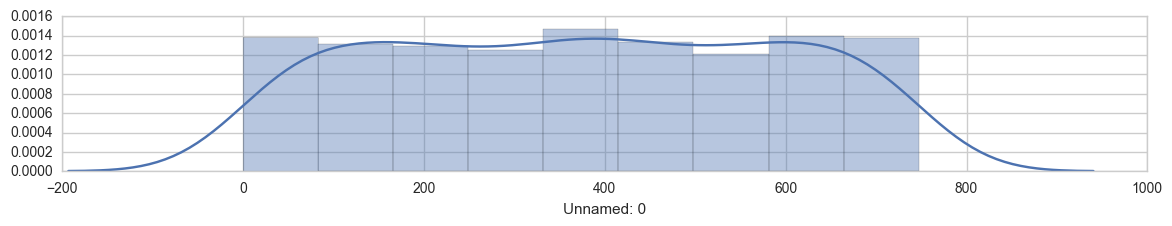

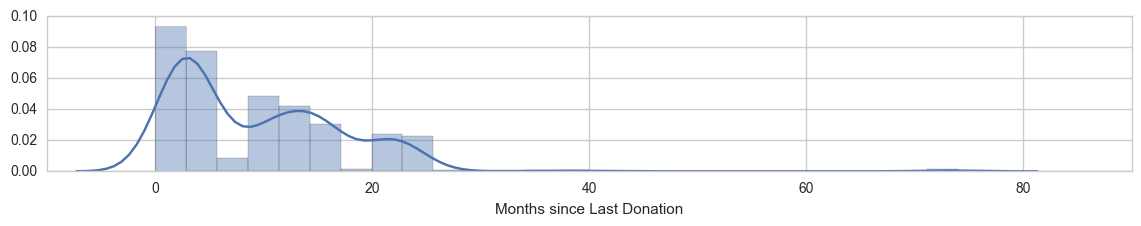

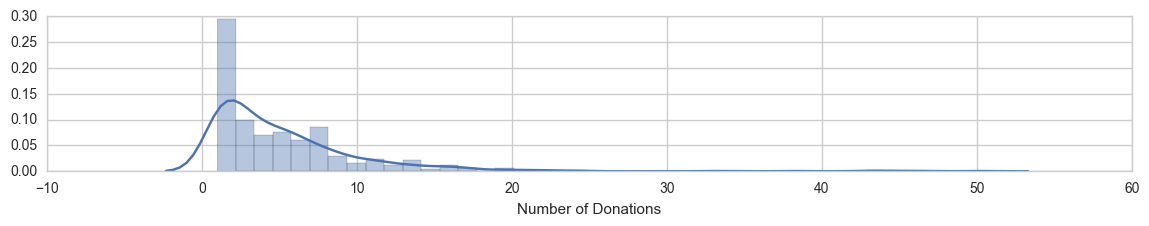

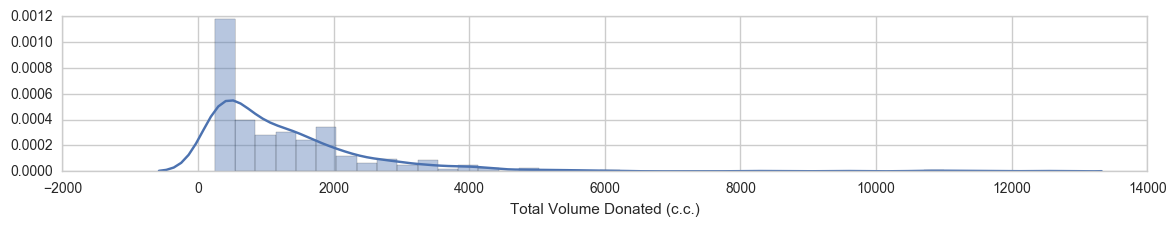

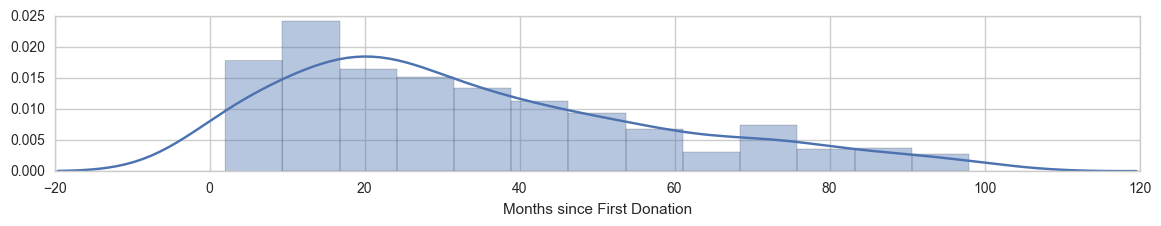

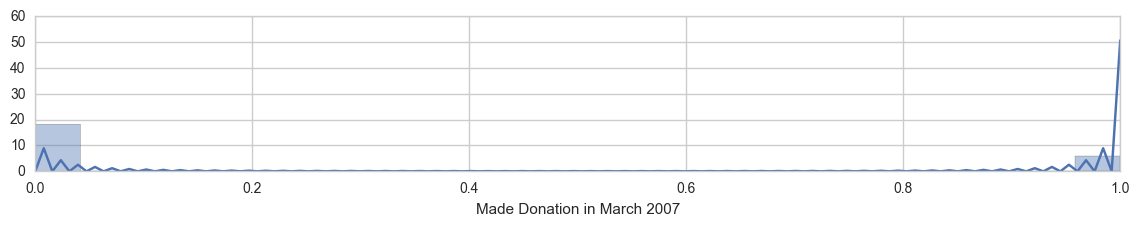

In [8]:
for column in trainingData.columns:
    plt.figure(figsize=(14,2))
    seaborn.distplot(trainingData[column])

## Model Selection

### Possible Models

In [9]:
from sklearn import ensemble, svm, linear_model, tree, neural_network, base, neighbors, naive_bayes
import xgboost

In [10]:
# {"model name" -> (class, params)}
modelTypes = {
    "Decision Tree": (tree.DecisionTreeClassifier, {}),
    "Random Forest": (ensemble.RandomForestClassifier, {}),
    "Gradient Boosting (sklearn)": (ensemble.GradientBoostingClassifier, {}),
    #"Gradient Boosting (xgboost)": (xgboost.XGBClassifier, {}),
    "Support Vector Machine": (svm.SVC, {"probability": True}),
    "Nearest Neighbors" : (neighbors.KNeighborsClassifier, {}),
    "Naive Bayes" : (naive_bayes.GaussianNB, {})
    
}

In [11]:
trainingData.columns

Index(['Unnamed: 0', 'Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'],
      dtype='object')

In [12]:
def applyModels(modelTypes, trainingData, responseVariable):
    XTrain = trainingData.ix[:, trainingData.columns.difference([responseVariable])]
    yTrain = trainingData.ix[:, responseVariable]
    responses = {}
    models = {}
    for (modelName, (ModelClass, params)) in modelTypes.items():
        print(modelName)
        model = ModelClass(**params)
        model.fit(XTrain, yTrain)
        response = model.predict(testData)
        responseP = model.predict_proba(testData)
        responses[modelName] = pandas.DataFrame({"response": pandas.Series(response), 
                                                 "probability": pandas.Series(responseP[:,1])})
        models[modelName] = model
    return (responses, models)

In [13]:
(responses, models) = applyModels(modelTypes, trainingData, responseVariable="Made Donation in March 2007")

Random Forest
Decision Tree
Nearest Neighbors
Gradient Boosting (sklearn)
Naive Bayes
Support Vector Machine


/usr/local/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


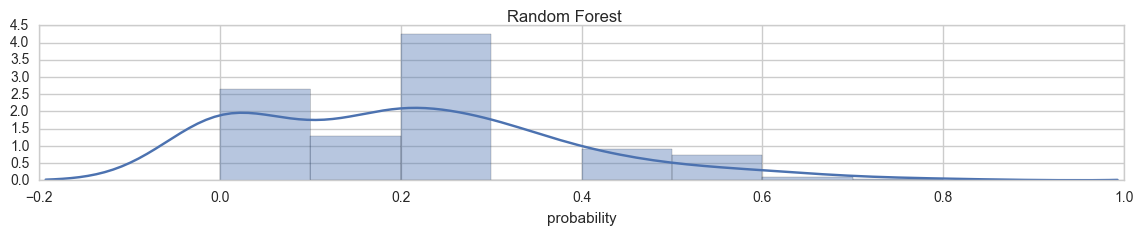

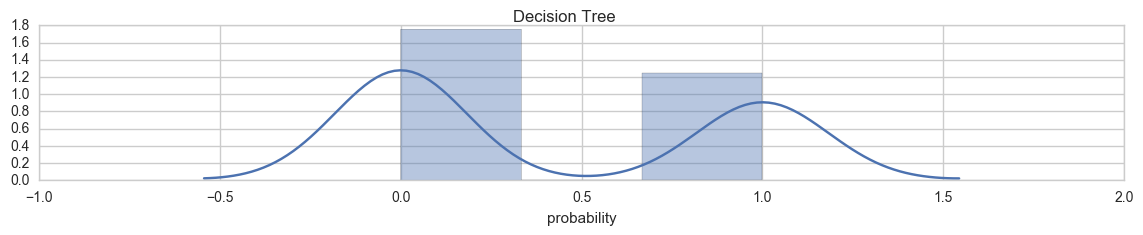

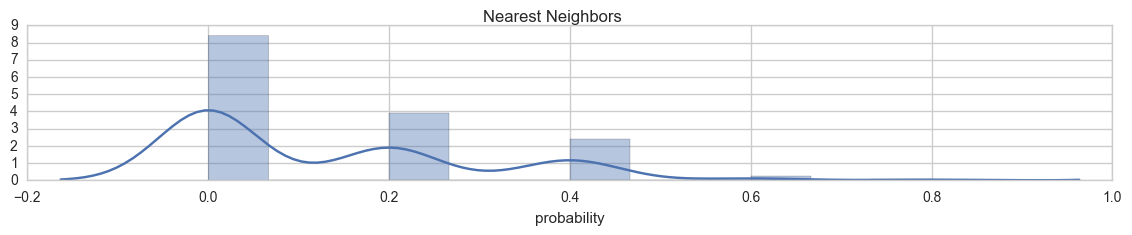

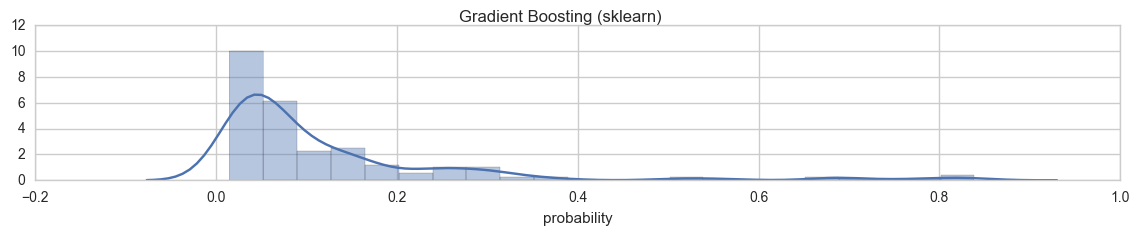

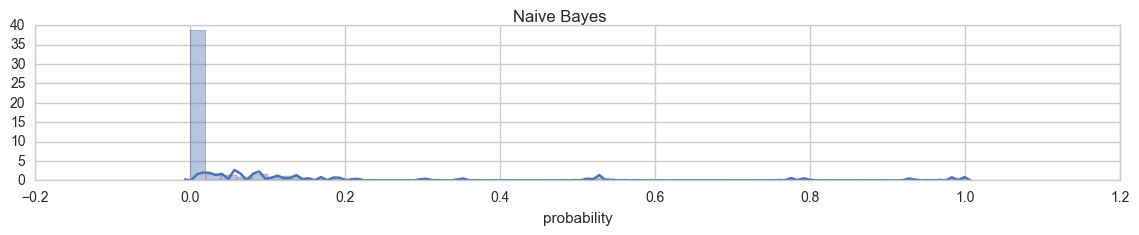

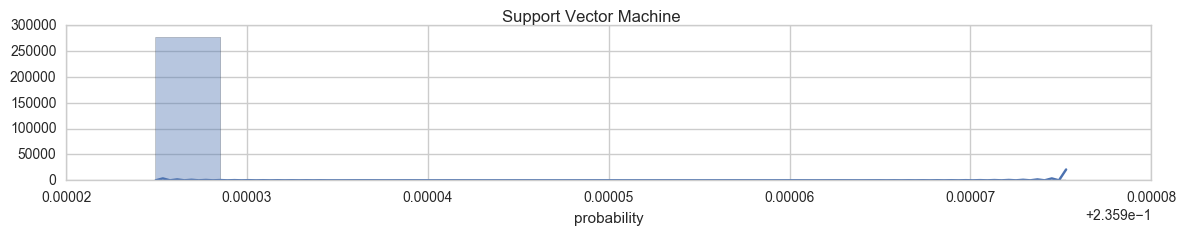

In [14]:
for (modelName, response) in responses.items():
    plt.figure(figsize=(14,2))
    seaborn.distplot(response["probability"])
    plt.suptitle(modelName)

### Cross-Validation

In [15]:
from sklearn import model_selection, metrics

In [16]:
metric = metrics.log_loss

In [35]:
def crossValidateModels(modelTypes, trainData, responseVariable):
    XTrain = trainingData.ix[:, trainingData.columns.difference([responseVariable])]
    yTrain = trainingData.ix[:, responseVariable]
    modelScores = {}
    for (modelName, (ModelClass, params)) in modelTypes.items():
        model = ModelClass(**params)
        print("cross-validating ", modelName)
        scores = model_selection.cross_val_score(scoring=metrics.make_scorer(metric, greater_is_better=False),
                                                cv=10,
                                                estimator=model,
                                                X=XTrain,
                                                y=yTrain)
        modelScores[modelName] = scores.mean()
    cvScoreData = pandas.DataFrame(list(modelScores.items()), columns=["model", "score"]).sort_values(by="score")
    cvScoreData.index = range(1,len(cvScores) + 1)
    return cvScoreData

In [36]:
cvScores = crossValidateModels(modelTypes, trainingData, responseVariable="Made Donation in March 2007")

cross-validating  Random Forest
cross-validating  Decision Tree
cross-validating  Nearest Neighbors
cross-validating  Gradient Boosting (sklearn)
cross-validating  Naive Bayes
cross-validating  Support Vector Machine


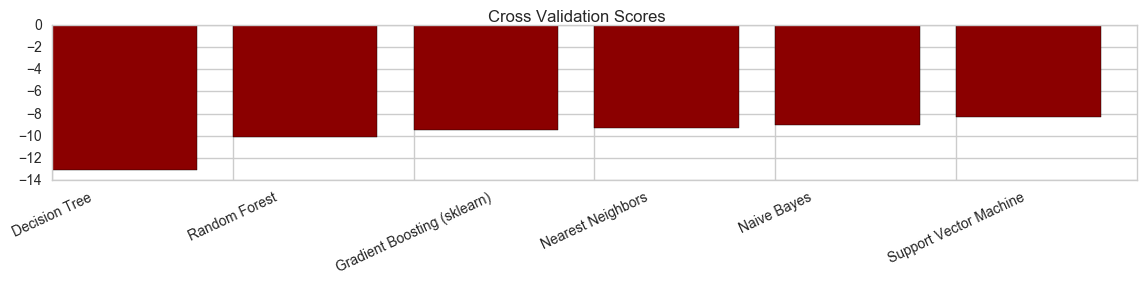

In [39]:
plt.figure(figsize=(14,2))
plt.bar(cvScores.index, cvScores["score"], color="darkred")
plt.xticks(cvScores.index, cvScores["model"], rotation=25)
plt.suptitle("Cross Validation Scores")
